In [4]:
%cd ../src

/Users/khanhhuyen/Downloads/iai-baby/src


In [5]:
import hydra
import pyrootutils
from omegaconf import DictConfig
from pytorch_lightning import LightningModule
import torch
from torchvision.utils import save_image
from datamodules.baby_datamodule import BabyDataModule
from datamodules.baby_segment_localized_datamodule import BabySegmentLocalizedDataModule
from models.baby_segment_module import BabySegmentLitModule

import torchvision.transforms as transforms
from models.postprocess.largest_connected_component import MaxAreaProcessor
import os
import matplotlib.pyplot as plt
from pytorch_lightning import LightningModule as L

from hydra import compose, initialize

import json
from collections import defaultdict

In [6]:
root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
root = pyrootutils.setup_root(root_path, dotenv=True, pythonpath=True)
print(root)
read_image = BabySegmentLocalizedDataModule(download=False).read_image
read_label = BabySegmentLocalizedDataModule(download=False).read_label
measure_nt_width = BabySegmentLitModule().measure_nt_width
plot_thickness = BabySegmentLitModule().plot_thickness
calculate_nt_thickness = BabySegmentLitModule().calculate_nt_thickness
transform = transforms.Resize(
                (320, 544),
                interpolation=transforms.InterpolationMode.NEAREST
                )

/Users/khanhhuyen/Downloads/iai-baby


In [7]:
from src.models.baby_segment_module import BabySegmentLitModule

In [8]:
# def infer():
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with initialize(version_base="1.2", config_path= "../configs"):
    cfg = compose(config_name="infer.yaml",return_hydra_config=True)
    model: L = hydra.utils.instantiate(cfg.model)
    model.load_state_dict(
        torch.load(cfg.ckpt_path, map_location=device)["state_dict"],
        strict=False
    )
    model.eval()
# infer()

In [31]:
import json
from collections import defaultdict
gt_keypoints_path = "/Users/khanhhuyen/Downloads/iai-baby/data/baby/nt_keypoints.json"
imgid_to_keypoints = defaultdict(lambda: [])
with open(gt_keypoints_path) as fin:
                keypoints = json.load(fin)
                for point in keypoints:
                    imgid_to_keypoints[point["image_id"]].extend([
                        point["p1"], point["p2"]
                    ])

torch.Size([1, 1, 211, 452])
torch.Size([1, 1, 320, 544])
Input image loaded successfully!
Output mask generated successfully!
Postprocessing done!
bbox: tensor([[[249, 481],
         [249, 481]]]) shape: torch.Size([1, 2, 2])
keypoints: tensor([[[218, 116],
         [221,  96]]]) shape: torch.Size([1, 2, 2])
keypoints: tensor([[[467, 597],
         [470, 577]]]) shape: torch.Size([1, 2, 2])


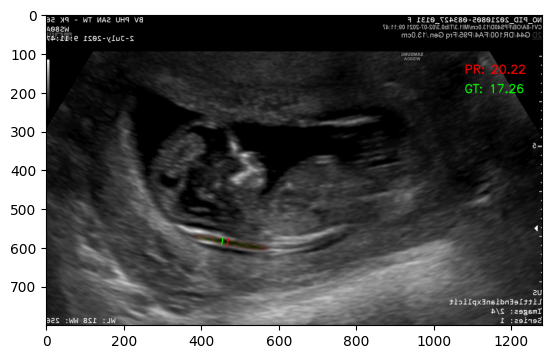

Thickness calculated successfully!


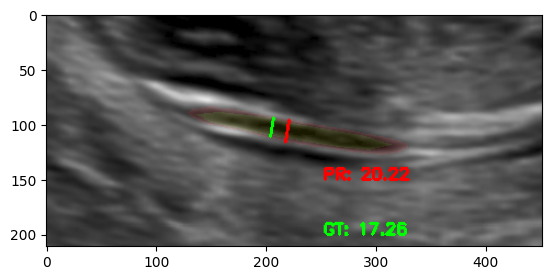

In [24]:
flipud = False
fliplr = True
orig_img = read_image(os.path.dirname(cfg.target_path) + "/source.png", greyscale=False).unsqueeze(0)
inp = read_image(cfg.input_path, greyscale=True).unsqueeze(0)
inp_=inp
inp = transform(inp)
print("Input image loaded successfully!")
out = model(inp)
out_mask = torch.argmax(out, dim=1)
print("Output mask generated successfully!")
postprocessor = MaxAreaProcessor()
# if postprocessor is not None:
out_mask = postprocessor(out_mask)
out_mask = transforms.Resize(inp_.shape[-2:], interpolation=transforms.InterpolationMode.NEAREST)(out_mask)
print("Postprocessing done!")
inp = inp_



img_mask = inp.repeat(3,1,1,1)
img_mask[0] = (out_mask == 1) * 0.1 + (inp[0] != 1) * img_mask[1]

gt_keypoints = None
gt_thickness = None
if os.path.exists(cfg.target_path):
    target = read_label(cfg.target_path).unsqueeze(0)
    img_mask[1] = (target[0][0] == 1) * 0.1 + (inp[0] != 1) * img_mask[1]
    
    image_id = "1B_0001_1"
    gt_keypoints = torch.tensor(imgid_to_keypoints[image_id]).int()

    gt_keypoints[:,0] = orig_img.shape[-1] - gt_keypoints[:,0] if fliplr else gt_keypoints[:,0]
    gt_keypoints[:,1] = orig_img.shape[-2] - gt_keypoints[:,1] if flipud else gt_keypoints[:,1]

    gt_keypoints = gt_keypoints.unsqueeze(0)
    gt_thickness = calculate_nt_thickness(gt_keypoints)

# add mask to input image, decrease opacity of mask
# gt_thickness = None
# gt_keypoints = None

with open(os.path.dirname(cfg.target_path) + "/bbox.txt") as f:
        x1, y1, x2, y2 = [int(x) for x in f.readline().split()]
        bbox = torch.tensor([[x1, y1], [x1, y1]]).unsqueeze(0)

print(f"bbox: {bbox} shape: {bbox.shape}")
keypoints = measure_nt_width(out_mask)
print(f"keypoints: {keypoints} shape: {keypoints.shape}") 
keypoints = keypoints + bbox
print(f"keypoints: {keypoints} shape: {keypoints.shape}")
thickness = calculate_nt_thickness(keypoints).to(device)

# plot_keypoints(keypoints, img_mask)
img_mask=img_mask.swapaxes(1,0)
orig_img[0][:, y1:y2, x1:x2] = img_mask[0]
img_mask = plot_thickness(img_mask, thickness, gt_thickness,keypoints-bbox, gt_keypoints-bbox, fontScale=0.5)
orig_img = plot_thickness(orig_img,thickness, gt_thickness,keypoints, gt_keypoints)

plt.imshow(orig_img[0].permute(1,2,0))
plt.show()
print("Thickness calculated successfully!")
save_image(img_mask, cfg.output_path)
plt.imshow(img_mask[0].permute(1,2,0))


In [25]:
keypoints

tensor([[[213, 173],
         [216, 141]]])

In [30]:
import pandas as pd
df=pd.read_csv("/Users/khanhhuyen/Downloads/iai-baby/data/baby/labels kssg.csv")
# image_id
df["image_id"]=df["FileName"].apply(lambda x: str(x).split(".")[0])
# df["p1"] is list [df["x1"],df["y1"]]
df["p1"]=df.apply(lambda x: [x["X1"],x["Y1"]],axis=1)
df["p2"]=df.apply(lambda x: [x["X2"],x["Y2"]],axis=1)

df = df[["image_id","p1","p2","PhyX","PhyY", "LabelDist", "DocDist"]]
df.to_json(gt_keypoints_path,orient="records")

# get row by image_id
df[df["image_id"]=="1B_0001_1"]


,image_id,p1,p2,PhyX,PhyY,LabelDist,DocDist
11,1B_0001_1,"[824.225854201367, 575.185074162282]","[827.242477327619, 592.058195478386]",0.008626,0.008626,1.478566,1.26


NameError: name 'gt_keypoints_path' is not defined

In [43]:
image_id = "1B_0001_1"
keypoints = imgid_to_keypoints[image_id]
gt = torch.tensor(keypoints)
gt

tensor([[824.2258, 575.1851],
        [827.2425, 592.0582]])

In [ ]:
!ls /home/pill/baby/iai-baby/configs

callbacks   debug      experiment  hparams_search  local   model  trainer
datamodule  eval.yaml  extras	   hydra	   logger  paths  train.yaml
